# Extracting data from Wikipedia

Reading raw input text from Wikipedia page "Paracetamol" from a text file in which only the hyperlink-references have been manually removed

In [1]:
fname = "/content/drive/MyDrive/Wiki-paracetamol.txt" #file is stored in my Google Drive account and can be accessed after mounting it

# open the file in read mode
file = open(fname,mode='r')
 
# read all lines at once
text = file.read()
 
# close the file
file.close()

# Installing/Downloading required packages

Downloading nltk to use tokenize and word_tokenize for tokenizing text into sentences and words resp.

In [2]:
import nltk
nltk.download('punkt')
from nltk import tokenize
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Downgrading Python to v3.7 and spacy to v2.1.0 to make it compatible with neuralcoref package, using en_core_web_sm for POS tagging

In [3]:
!apt-get install python3.7
!pip uninstall -q neuralcoref -y > /dev/null
!pip install -q neuralcoref --no-binary neuralcoref > /dev/null

!pip uninstall -q spacy -y > /dev/null
!pip install -q -U spacy==2.1.0 > /dev/null
!python -m spacy download en_core_web_sm > /dev/null

import spacy
import neuralcoref
import en_core_web_sm

nlp = en_core_web_sm.load()
neuralcoref.add_to_pipe(nlp)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3.7 is already the newest version (3.7.13-1+bionic3).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


Importing pandas, spacy.matcher packages for data manipulation and matplotlib, networkx for graph visualization and tqdm for progress bars

In [4]:
import re
import pandas as pd

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)

# Data Pre-processing

Function for coreference resolution in the text using neuralcoref

In [5]:
def coref_resolution(text):
    doc = nlp(text)
    # fetches tokens with whitespaces from spacy document
    tok_list = list(token.text_with_ws for token in doc)
    for cluster in doc._.coref_clusters:
        # get tokens from representative cluster name
        cluster_main_words = set(cluster.main.text.split(' '))
        for coref in cluster:
            if coref != cluster.main:  # if coreference element is not the representative element of that cluster
                if coref.text != cluster.main.text and bool(set(coref.text.split(' ')).intersection(cluster_main_words)) == False:
                    # if coreference element text and representative element text are not equal and none of the coreference element words are in representative element. This was done to handle nested coreference scenarios
                    tok_list[coref.start] = cluster.main.text + \
                        doc[coref.end-1].whitespace_
                    for i in range(coref.start+1, coref.end):
                        tok_list[i] = ""

    return "".join(tok_list)

text = coref_resolution(text)

Removing a custom-curated list of stopwords from the resolved text and breaking it up into sentences (using nltk tokenizer) for POS tagging

In [17]:
stop_words = ['a', 'an', 'the', 'and', 'are', 'its','for', 'with', 'where', 'when', 'of', 'there', 'true', 'which', 'this', 'that', 'they', 'them', 'only', 'however', 'well']
  
word_tokens = word_tokenize(text)
  
filtered_text = [w for w in word_tokens if not w.lower() in stop_words]
text = " ".join(filtered_text)
print(text)

text = text.replace("paracetamol", "Paracetamol")

sentences = tokenize.sent_tokenize(text)
len(sentences)
doc = nlp(sentences[2])

for tok in doc:
  print(tok.text, "...", tok.dep_)

Paracetamol , also known as acetaminophen , Paracetamol medication used to treat fever mild to moderate pain . Common brand names include Tylenol Panadol . At standard dose , paracetamol slightly decreases body temperature ; paracetamol is inferior to ibuprofen in , benefits paracetamol use fever unclear . Paracetamol may relieve pain in acute mild migraine but slightly in episodic tension headache . , aspirin/paracetamol/caffeine combination helps both conditions pain is mild is recommended as first-line treatment . Paracetamol is effective post-surgical pain , but Paracetamol is inferior to ibuprofen . paracetamol/ibuprofen combination provides further increase in potency is superior to either drug alone . Paracetamol pain relief provides in osteoarthritis is small clinically insignificant . evidence in favor use in low back pain , cancer pain , neuropathic pain is insufficient . In short term , common side effects paracetamol nausea abdominal pain , it seems to have tolerability sim

In [18]:
doc = nlp(sentences[-6])

for tok in doc:
  print(tok.text, "...", tok.dep_)

Paracetamol ... compound
poisoning ... nsubj
is ... ccomp
foremost ... advmod
cause ... attr
acute ... amod
liver ... compound
failure ... dobj
in ... prep
Western ... amod
world ... pobj
, ... punct
accounts ... ROOT
most ... amod
drug ... compound
overdoses ... dobj
in ... prep
United ... compound
States ... pobj
, ... punct
United ... compound
Kingdom ... conj
, ... punct
Australia ... conj
, ... punct
New ... compound
Zealand ... npadvmod
. ... punct


# Data Processing

Extracting all subject-object pairs for each sentence using their assigned POS tags (en_core_web_sm) and naive logic to best combine them

In [19]:
def get_entities(text):
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""
  
  for tok in nlp(text):
    # if token is a punctuation mark then ignore
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      # extracting subject from sentence
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      # extracting objects from sentence
      if tok.dep_.find("obj") == True:
        #appending all possible objects in the sentence to try to capture more info, delimited by '$#*' special pattern
        ent2 = ent2 + "$#*"+ modifier +" "+ prefix +" "+ tok.text 
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""
        
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

Collecting all subj-obj pairs from the pre-processed text and splitting the object string to try to capture more info with more obj per subj

In [20]:
count_obj = []
temp_pairs = []
entity_pairs = []
# Collecting all subj-obj pairs from the pre-processed text
for i in tqdm(sentences):
  entity_pairs.append(get_entities(i))
#Iterating through the pair list to check for multiple objects appended in a single obj string
for pair in tqdm(entity_pairs):
  c = 0
  list = pair[1].split("$#*")
  for tok in list:
    tok = tok.strip()
    if(not tok == ""):
      #adding the new pairs of objects keeping the same subj of the sentence 
      temp_pairs.append([pair[0], tok])
      c+=1
  #keeping track of counts of all pairs with same subject of the same sentence
  count_obj.append(c)

entity_pairs = temp_pairs
print(len(entity_pairs))
entity_pairs

100%|██████████| 23/23 [00:00<00:00, 73696.71it/s]

57


[['Paracetamol medication', 'also  acetaminophen'],
 ['Paracetamol medication', 'fever'],
 ['Paracetamol medication', 'mild'],
 ['Paracetamol medication', 'moderate  pain'],
 ['Common brand names', 'Tylenol Panadol'],
 ['in  Paracetamol', 'standard  dose'],
 ['in  Paracetamol', 'slightly body temperature'],
 ['in  Paracetamol', 'use fever'],
 ['Paracetamol', 'pain'],
 ['Paracetamol', 'mild  migraine'],
 ['Paracetamol', 'episodic tension headache'],
 ['conditions pain', 'first line treatment'],
 ['Paracetamol ibuprofen combination', 'further  increase'],
 ['Paracetamol ibuprofen combination', 'potency'],
 ['Paracetamol ibuprofen combination', 'drug'],
 ['provides', 'osteoarthritis'],
 ['neuropathic cancer pain', 'favor use'],
 ['neuropathic cancer pain', 'back  pain'],
 ['it', 'short  term'],
 ['it', 'abdominal side pain'],
 ['it', 'tolerability'],
 ['Chronic consumption Paracetamol', 'drop'],
 ['Chronic consumption Paracetamol', 'hemoglobin level'],
 ['Chronic consumption Paracetamol',

Naively extracting relationships between subj-obj per sentence by using ROOT tags (as I couldn't use BERT models due to resource constraints)

In [21]:
def get_relation(text):

  doc = nlp(text)

  #Matcher class object 
  matcher = Matcher(nlp.vocab)

  #Defining custom match pattern revolving around the ROOT of the sentence
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
  #Add only what matches with the pattern from each sentence to capture the relationships
  matcher.add("matching_1", None, pattern) 

  #Extracting all the relationships in each sentence and returning the span
  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

Collecting relations from each sentences and naively duplicating the same, for all the multiple subj-obj pairs collected from the same sentence

In [22]:
temp = []
relations = []

#Extracting the relations from each sentence of the processed sentences
for i in tqdm(sentences):
  relations.append(get_relation(i))

#Naively duplicating the relation in each sentence depending on the number of subj-obj pairs with same subject of the same sentence
for i in range(len(relations)):
  for j in range(count_obj[i]):
    temp.append(relations[i])

relations = temp
#Displaing the count of each relationship that appears in the text
pd.Series(relations).value_counts()

100%|██████████| 23/23 [00:00<00:00, 43.30it/s]


suggest                7
used                   6
increased              5
observed in            4
accounts most          4
result in              3
is available           3
is inferior            3
relieve                3
seems                  3
provides further       3
is insufficient        2
lead to                2
was 145th              2
include                1
increase               1
helps                  1
recommended maximum    1
is small               1
made in                1
is on                  1
dtype: int64

# Extracting source-relation-target triplets

Creating a dataframe from all the extracted triplets from our text

In [23]:
#extracting subjects
source = [i[0] for i in entity_pairs]

#extracting objects
target = [i[1] for i in entity_pairs]

#creating dataframe for processing
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

#storing the extracted triplets in the required format in a dataframe
triplets = pd.DataFrame({'source':source, 'relations':relations, 'target':target})
triplets

,source,relations,target
0,Paracetamol medication,used,also acetaminophen
1,Paracetamol medication,used,fever
2,Paracetamol medication,used,mild
3,Paracetamol medication,used,moderate pain
4,Common brand names,include,Tylenol Panadol
5,in Paracetamol,is inferior,standard dose
6,in Paracetamol,is inferior,slightly body temperature
7,in Paracetamol,is inferior,use fever
8,Paracetamol,relieve,pain
9,Paracetamol,relieve,mild migraine


Storing the triplets into a deliverable text file

In [24]:
#The file where the list of triples are being stored is hosted as deliverable of same name in the Dropbox link
with open('/content/drive/MyDrive/Extracted_triplets.txt', 'w') as f:
    dfAsString = triplets.to_string(header=False, index=False)
    f.write(dfAsString)

# Knowledge Graph visualization using networkx package

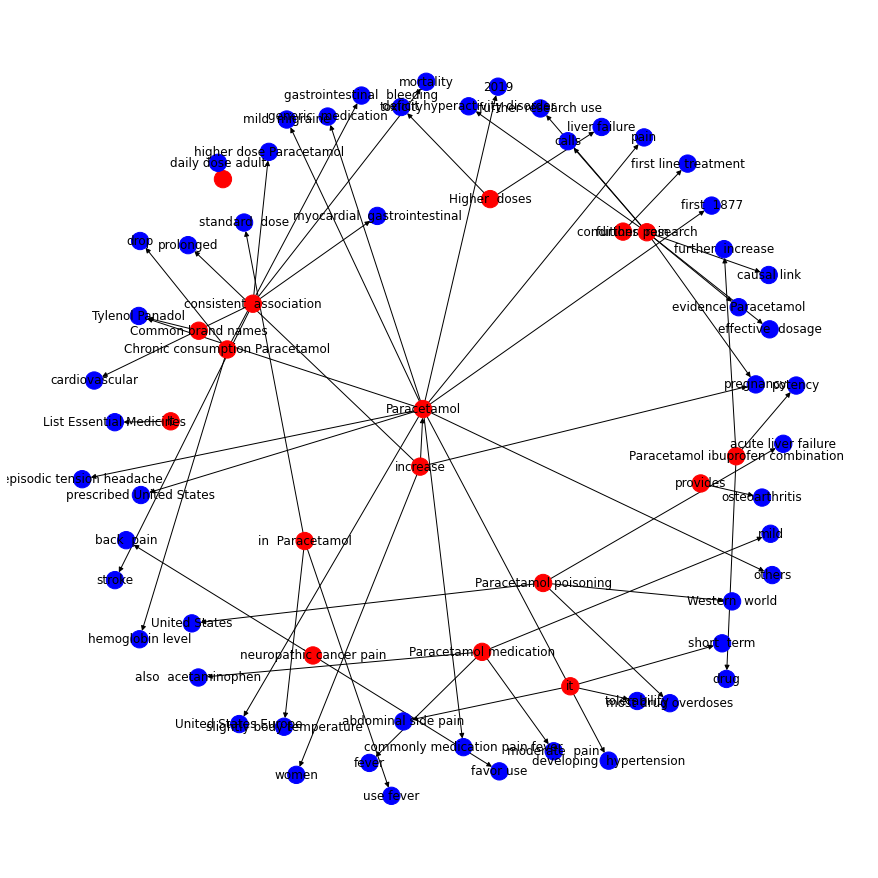

In [25]:
#creating the digraph edge list from the dataframe used for further manipulation
G=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

#setting the graph layout most suitable for Knowledge graph representation
pos = nx.spring_layout(G)

#creating custom list of 2 different colors depending whether the node is subject or object
node_colors = []
for n in G.nodes():
  if n in source:
    node_colors.append('red')
  else:
    node_colors.append('blue')

#plotting the graph with custom layout and color scheme
nx.draw(G, with_labels=True, node_color=node_colors, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

#the edge labels have been omitted deliberately to aid clarity of viewing and also because the relations captured aren't very sophisticated